In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from SSMs import SSM
from os.path import dirname, join as pjoin
import torch
print(torch.cuda.is_available())
from torch import nn
import time

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

plt.close('all')
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel = data_max['maxTrit'], data_max['maxTman']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

False
False


In [2]:
# Initialize input and output tensors
u = torch.zeros(nExp, t_end-1, 5) # add the previous output to the input
y = torch.zeros(nExp, t_end-1, 2)

# Set input number
inputnumberD = 4

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp[0, j][1:, 3:]),    # Take columns 3 onwards from dExp
        torch.from_numpy(buildtot[j * t_end + 1: (j + 1) * t_end, 0]).unsqueeze(1),  # Ensure proper shape for buildtot
        torch.from_numpy(yExp[0, j][:-1, :])     # Take previous outputs from yExp to give as new inputs
    ),
    dim=-1
)
   
    y[j, :, :] = (torch.from_numpy(yExp[0, j][1:,:]))
    
seed = 55
torch.manual_seed(seed)

In [3]:
idd = 5
hdd = 500
odd = yExp[0, 0].shape[1]

RNN = (SSM
       (#N=3,
        in_features=idd,
        out_features=odd,
        #mid_features=21,
        state_features=hdd,
        scan = True,
        ))
if (torch.cuda.is_available()):
    RNN.cuda()

total_params = sum(p.numel() for p in RNN.parameters())
print(f"Number of parameters: {total_params}")

#RNN = torch.jit.script(RNN)

MSE = nn.MSELoss()

# Define Optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
optimizer.zero_grad()

t_end = yExp[0, 0].shape[0]

epochs = 300
LOSS = np.zeros(epochs)


Number of parameters: 6040


In [4]:

t0= time.time()
for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    yRNN = RNN(u)
    yRNN = torch.squeeze(yRNN)
    loss = MSE(yRNN, y)
    loss.backward()
    print(u.grad)
    optimizer.step()
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss

t1= time.time()

total_time= t1-t0

None
Epoch: 1 	||	 Loss: 0.5524130463600159
None
Epoch: 2 	||	 Loss: 0.15436258912086487
None
Epoch: 3 	||	 Loss: 0.2042451649904251
None
Epoch: 4 	||	 Loss: 0.02870672382414341
None
Epoch: 5 	||	 Loss: 0.07037556916475296
None
Epoch: 6 	||	 Loss: 0.11512327939271927
None
Epoch: 7 	||	 Loss: 0.08888110518455505
None
Epoch: 8 	||	 Loss: 0.043988727033138275
None
Epoch: 9 	||	 Loss: 0.03876687213778496
None
Epoch: 10 	||	 Loss: 0.02588471584022045
None
Epoch: 11 	||	 Loss: 0.019043663516640663
None
Epoch: 12 	||	 Loss: 0.022664949297904968
None
Epoch: 13 	||	 Loss: 0.03115592896938324
None
Epoch: 14 	||	 Loss: 0.030706340447068214
None
Epoch: 15 	||	 Loss: 0.021993417292833328
None
Epoch: 16 	||	 Loss: 0.014687297865748405
None
Epoch: 17 	||	 Loss: 0.007270005997270346
None
Epoch: 18 	||	 Loss: 0.006918963044881821
None
Epoch: 19 	||	 Loss: 0.01228176150470972
None
Epoch: 20 	||	 Loss: 0.011542616412043571
None
Epoch: 21 	||	 Loss: 0.008878636173903942
None
Epoch: 22 	||	 Loss: 0.0088772

In [5]:
nExp = yExp_val.size
t_end = yExp_val[0,0].shape[0]
uval = torch.zeros(nExp, t_end-1, 5)
yval = torch.zeros(nExp, t_end-1, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
    (
        torch.from_numpy(dExp_val[0, j][1:, 3:]),    # Take columns 3 onwards from dExp
        torch.from_numpy(buildtot_val[j * t_end + 1 : (j + 1) * t_end, 0]).unsqueeze(1),  # Ensure proper shape for buildtot
        torch.from_numpy(yExp_val[0, j][:-1, :])  # Take previous outputs from yExp to give as new inputs
    ),
    dim=-1
)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j][1:,:]))

yRNN_val = RNN(uval)
yRNN_val = torch.squeeze(yRNN_val)
yval = torch.squeeze(yval)

loss_val = MSE(yRNN_val, yval)

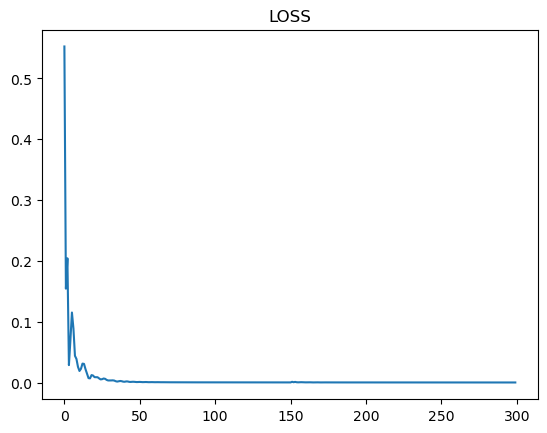

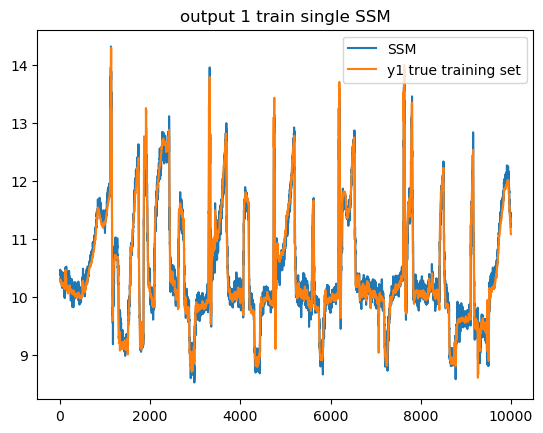

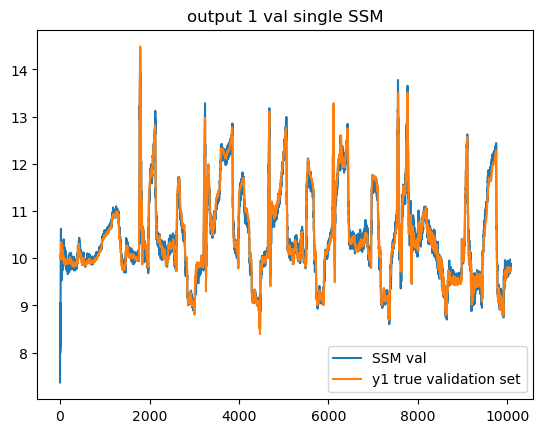

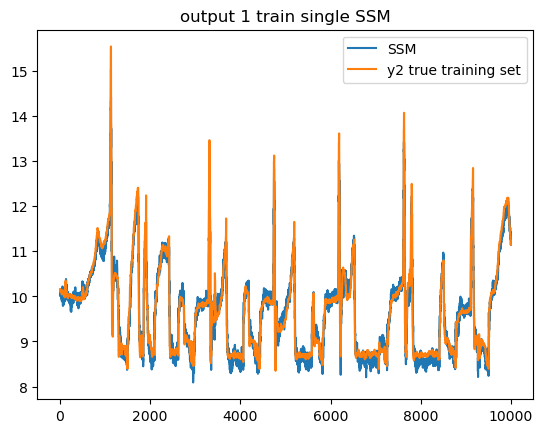

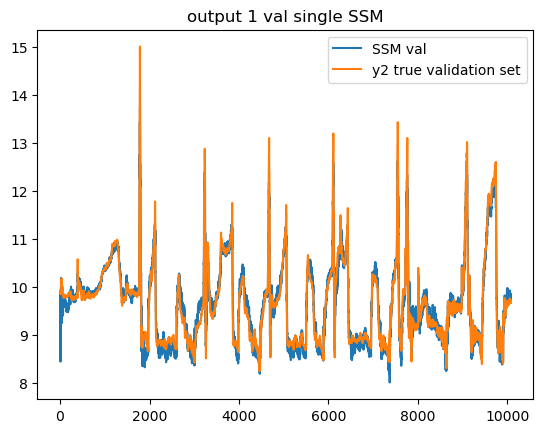

Loss Validation single RNN: 0.00013079620839562267


In [6]:
plt.figure('8')
plt.plot(LOSS)
plt.title("LOSS")
plt.show()

plt.figure('9')
plt.plot(maxTdel.item()*yRNN[0, 10000:20000, 0].cpu().detach().numpy(), label='SSM')
plt.plot(maxTdel.item()*y[0, 10000:20000, 0].cpu().detach().numpy(), label='y1 true training set')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

plt.figure('10')
plt.plot(maxTdel.item()*yRNN_val[:, 0].cpu().detach().numpy(), label='SSM val')
plt.plot(maxTdel.item()*yval[:, 0].cpu().detach().numpy(), label='y1 true validation set')
plt.title("output 1 val single SSM")
plt.legend()
plt.show()

plt.figure('11')
plt.plot(maxTrit.item()*yRNN[0, 10000:20000, 1].cpu().detach().numpy(), label='SSM')
plt.plot(maxTrit.item()*y[0, 10000:20000, 1].cpu().detach().numpy(), label='y2 true training set')
plt.title("output 1 train single SSM")
plt.legend()
plt.show()

plt.figure('12')
plt.plot(maxTrit.item()*yRNN_val[:, 1].cpu().detach().numpy(), label='SSM val')
plt.plot(maxTrit.item()*yval[:, 1].cpu().detach().numpy(), label='y2 true validation set')
plt.title("output 1 val single SSM")
plt.legend()
plt.show()

# plt.figure('15')
# plt.plot(d[inputnumberD, :].detach().numpy(), label='input train')
# plt.plot(dval[inputnumberD, :].detach().numpy(), label='input val')
# plt.title("input single REN")
# plt.legend()
# plt.show()

print(f"Loss Validation single RNN: {loss_val}")